# Calculate the hexagon metrics
1. Distance from urban center


In [40]:
import pandas as pd
import os
import h3
from glob import glob
# compute the harvesine distance between the (lat, lon) of the hex_id and the urban center
import haversine as hs
from haversine import Unit

res_exclude = 11
CURATE_FOLDER_SOURCE = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifiier_prob_hex_summary"
CURATE_FOLDER_EXPORT = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifiier_prob_similarity"

files = glob(CURATE_FOLDER_SOURCE + f"/*res_exclude={res_exclude}.parquet")

city_meta = pd.read_csv("/home/yuanzf/uvi-time-machine/_script/city_meta.csv")
city_meta = city_meta[['center_lat', 'center_lng', 'City']]
city_meta['city_lower'] = city_meta['City'].str.lower().replace(' ', '')

In [10]:
# load all h3 indexes and urban center
files = glob(CURATE_FOLDER_SOURCE + f"/*res_exclude={res_exclude}.parquet")
print(len(files))
df_all = []
for f in files:
    temp = pd.read_parquet(f)
    temp = temp[temp['res'].isin([6,7])].reset_index(drop = True)
    temp['city_lower'] = os.path.basename(f).split("_")[1].replace("city=", "").replace(" ", "").lower()
    df_all.append(temp)
df_all = pd.concat(df_all).drop_duplicates('hex_id').reset_index(drop = True)


112


In [12]:
df_all = df_all[['hex_id', 'res', 'city_lower']]
# get the lat lon center of the hex_id
import h3
df_all['lat'] = df_all['hex_id'].apply(lambda x: h3.h3_to_geo(x)[0])
df_all['lon'] = df_all['hex_id'].apply(lambda x: h3.h3_to_geo(x)[1])

In [19]:
df_all_update = df_all.merge(city_meta, on = 'city_lower', how = 'inner')

df_all_update['h3_cbd_dist'] = df_all_update.apply(lambda x: hs.haversine((x['lat'], x['lon']), (x['center_lat'], x['center_lng']), 
                                                                       unit = Unit.METERS), axis = 1)

Text(0, 0.5, 'Frequency')

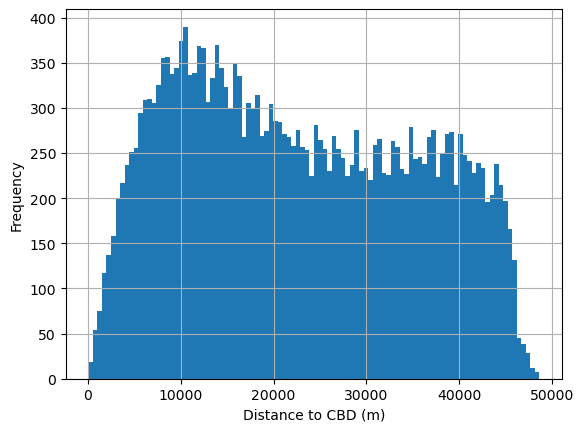

In [22]:
import matplotlib.pyplot as plt
df_all_update['h3_cbd_dist'].hist(bins = 100)
# x-label
plt.xlabel('Distance to CBD (m)')
# y-label
plt.ylabel('Frequency')

# compute hex to hex distance per resolution

In [ ]:
res_sel = 6
df_current = df_all[df_all['res'] == res_sel].drop_duplicates('hex_id').reset_index(drop = True)
# compute the pairwise havesine distance between the hex_id
dist_matrix = df_current[['lat', 'lon']].values
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
dist_matrix = haversine_distances(dist_matrix, dist_matrix) # unit: km
dist_matrix = np.triu(dist_matrix, k=1)
# dist_matrix = pd.DataFrame(dist_matrix, index = df_current['hex_id'], columns = df_current['hex_id'])
dist_matrix = pd.DataFrame(dist_matrix, index = df_current['hex_id'].values, columns = df_current['hex_id'].values)
dist_matrix_df = pd.DataFrame(dist_matrix).reset_index()
dist_matrix_df.columns = ["hex_id1", "hex_id2", "dist_pair"]
dist_matrix_df = dist_matrix_df[dist_matrix_df['dist_pair'] > 0].reset_index(drop = True)
dist_matrix_df.to_parquet(CURATE_FOLDER_EXPORT + f"/h3_hex_pairwise_dist_res={res_sel}.parquet")

In [44]:
import gc
gc.collect()

0

# load similarity index

In [ ]:
res_sel = 6
# dist_matrix_df = pd.read_parquet(CURATE_FOLDER_EXPORT + f"/h3_hex_pairwise_dist_res={res_sel}.parquet")
similarit_summary_overall = pd.read_csv(os.path.join(CURATE_FOLDER_EXPORT, f'similarity_summary_connection_res={res_sel}.csv'))\
    .rename(columns ={0:'count'})
similarit_summary_overall

,Unnamed: 0,city_1,city_2,0
0,0,Accra,Accra,289
1,1,Accra,Amsterdam,3060
2,2,Accra,Astrakhan,187
3,3,Accra,Athens,1649
4,4,Accra,Bacolod,204
...,...,...,...,...
12316,12316,Zwolle,Vienna,210
12317,12317,Zwolle,Vijayawada,60
12318,12318,Zwolle,Warsaw,280
12319,12319,Zwolle,Yamaguchi,1800


In [72]:

files = glob(CURATE_FOLDER_EXPORT + f"/*res={res_sel}*.parquet")
files = [f for f in files if "similarity" in f]
similarity_df =[]
for f in files:
    temp = pd.read_parquet(os.path.join(CURATE_FOLDER_EXPORT,f))
    similarity_df.append(temp)
similarity_df = pd.concat(similarity_df).reset_index(drop = True)

In [56]:
similarit_summary_overall = \
similarity_df.groupby(['city_1', 'city_2'])['similarity'].mean().reset_index().sort_values('similarity', ascending = False)\
    .rename(columns = {'similarity':'mean_similarity'})
similarit_summary_overall = similarit_summary_overall[similarit_summary_overall['mean_similarity'] > 0].reset_index(drop = True)


In [63]:
similarit_summary_overall_meta = similarit_summary_overall.merge(city_meta[['center_lat', 'center_lng', 'City']], 
                                                                 left_on = 'city_1', right_on = 'City', how = 'inner')\
                                                                     .drop(columns = ['City'])\
                                                        .merge(city_meta[['center_lat', 'center_lng', 'City']], 
                                                                 left_on = 'city_2', right_on = 'City', how = 'inner')\
                                                                     .drop(columns = ['City'])
similarit_summary_overall_meta.head()

,city_1,city_2,mean_similarity,center_lat_x,center_lng_x,center_lat_y,center_lng_y
0,Okayama,Yamaguchi,0.699900,34.655531,133.919795,34.178294,131.473843
1,Okayama,Fukuoka,0.695281,34.655531,133.919795,33.590184,130.401689
2,Fukuoka,Yamaguchi,0.678667,33.590184,130.401689,34.178294,131.473843
3,Amsterdam,Zwolle,0.601559,52.367600,4.904100,52.516775,6.083022
4,Bangalore,Hyderabad,0.544917,12.971599,77.594566,17.406500,78.477200


<Axes: >

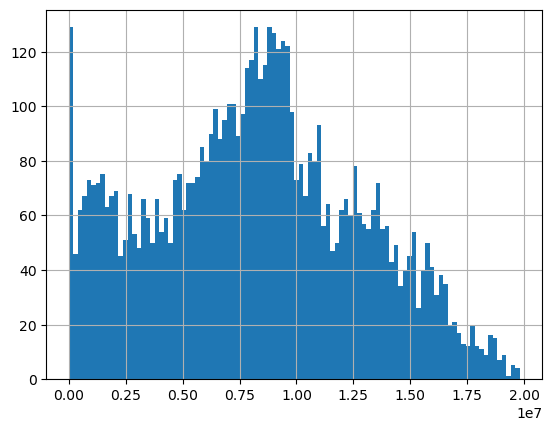

In [89]:
similarit_summary_overall_meta['center_dist'] = similarit_summary_overall_meta.apply(lambda x: hs.haversine((x['center_lat_x'], x['center_lng_x']),
                                                                                                        (x['center_lat_y'], x['center_lng_y']),
                                                                                                        unit = Unit.METERS), axis = 1)
similarit_summary_overall_meta['center_dist'].hist(bins = 100)

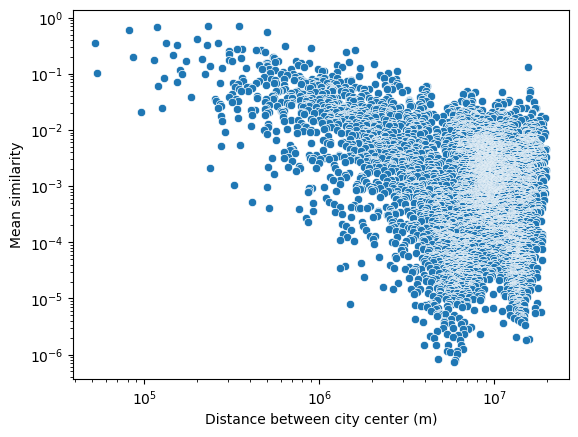

In [92]:
sns.scatterplot(data = similarit_summary_overall_meta, x = 'center_dist', y = 'mean_similarity')
# x-label
plt.xlabel('Distance between city center (m)')
# y-label
plt.ylabel('Mean similarity')
# use log for x-axis
plt.xscale('log')
# use log for y-axis
plt.yscale('log')

In [66]:
# similarit_summary_overall = similarit_summary_overall[similarit_summary_overall['mean_similarity'] > 0.005].reset_index(drop = True)
# print(similarit_summary_overall.shape)
similarit_summary_overall_meta.to_csv(os.path.join(CURATE_FOLDER_EXPORT, f'similarity_summary_connection_res={res_sel}.csv'), index = False)

Text(0, 0.5, 'Frequency')

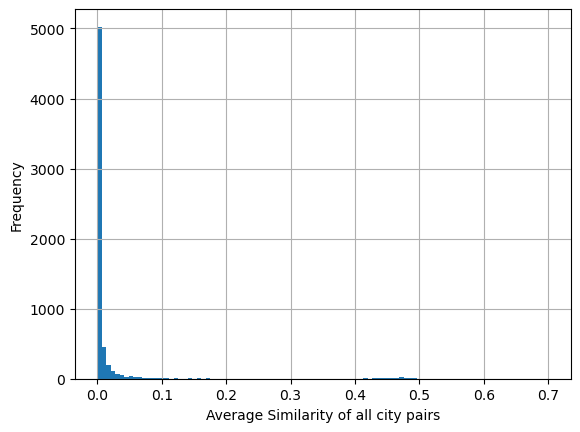

In [65]:
# plot histogram
similarit_summary_overall['mean_similarity'].hist(bins = 100)
# x-label
plt.xlabel('Average Similarity of all city pairs')
# y-label
plt.ylabel('Frequency')

In [ ]:
similarity_df_an = similarity_df[(similarity_df['dist_pair'].isna())&(similarity_df['similarity']>0)]\
    .reset_index().drop(['dist_pair'], axis = 1)\
    .merge(dist_matrix_df,
           left_on = ['hex_id1', 'hex_id2'], right_on = ['hex_id1', 'hex_id2'], how = 'inner')
similarity_df_an.head()

,index,hex_id1,hex_id2,similarity,city_1,city_2,dist_pair
0,3659,86608b017ffffff,86608b037ffffff,0.999844,Mumbai,Mumbai,0.055864
1,3660,86608b017ffffff,86608b0a7ffffff,0.999961,Mumbai,Mumbai,0.058595
2,3661,86608b017ffffff,86608b0b7ffffff,0.999967,Mumbai,Mumbai,0.117087
3,3662,86608b017ffffff,86608b18fffffff,0.999714,Mumbai,Mumbai,0.056331
4,3663,86608b017ffffff,86608b19fffffff,0.999646,Mumbai,Mumbai,0.100322


In [87]:
similarity_df_an[similarity_df_an['city_1']=='Mumbai'].sort_values('dist_pair', ascending = True).head(10)

,hex_id1,hex_id2,similarity,city_1,city_2,dist_pair,same_city
3115,86608b0b7ffffff,86608b19fffffff,0.999643,Mumbai,Mumbai,0.055655,True
2078,86608b0a7ffffff,86608b18fffffff,0.999835,Mumbai,Mumbai,0.055778,True
0,86608b017ffffff,86608b037ffffff,0.999844,Mumbai,Mumbai,0.055864,True
2079,86608b0a7ffffff,86608b19fffffff,0.999744,Mumbai,Mumbai,0.055956,True
3,86608b017ffffff,86608b18fffffff,0.999714,Mumbai,Mumbai,0.056331,True
2077,86608b0a7ffffff,86608b0b7ffffff,0.999957,Mumbai,Mumbai,0.058493,True
1,86608b017ffffff,86608b0a7ffffff,0.999961,Mumbai,Mumbai,0.058595,True
4150,86608b18fffffff,86608b19fffffff,0.999921,Mumbai,Mumbai,0.058615,True
1041,86608b037ffffff,86608b18fffffff,0.999718,Mumbai,Mumbai,0.058684,True
3910,86608b0b7ffffff,862db049fffffff,0.000082,Mumbai,Jerusalem,0.078359,False


In [74]:
similarity_df_an['same_city'] = similarity_df_an['city_1'] == similarity_df_an['city_2']

In [75]:
similarity_df_an = similarity_df_an.drop('index', axis = 1)

In [76]:
similarity_df_an_dif = similarity_df_an[similarity_df_an['same_city'] == False].reset_index(drop = True)

In [83]:
similarity_df_an

,hex_id1,hex_id2,similarity,city_1,city_2,dist_pair,same_city
0,86608b017ffffff,86608b037ffffff,0.999844,Mumbai,Mumbai,0.055864,True
1,86608b017ffffff,86608b0a7ffffff,0.999961,Mumbai,Mumbai,0.058595,True
2,86608b017ffffff,86608b0b7ffffff,0.999967,Mumbai,Mumbai,0.117087,True
3,86608b017ffffff,86608b18fffffff,0.999714,Mumbai,Mumbai,0.056331,True
4,86608b017ffffff,86608b19fffffff,0.999646,Mumbai,Mumbai,0.100322,True
...,...,...,...,...,...,...,...
11033248,8648b3977ffffff,862aacb07ffffff,0.002543,Reynosa,Philadelphia,0.549805,False
11033249,8648b3977ffffff,862aacb0fffffff,0.011191,Reynosa,Philadelphia,0.546934,False
11033250,8648b3977ffffff,862aacb27ffffff,0.002278,Reynosa,Philadelphia,0.594787,False
11033251,8648b3977ffffff,862aacb2fffffff,0.017912,Reynosa,Philadelphia,0.587525,False


In [79]:
similarity_df_an_mean = similarity_df_an_dif.groupby(['city_1', 'city_2'])\
    .agg({'similarity':'mean', 'dist_pair':'mean'}).reset_index()
similarity_df_an_mean = similarity_df_an_mean.rename(columns = {'similarity':'mean_similarity', 'dist_pair':'mean_dist_pair'})

Text(0, 0.5, 'Average Similarity')

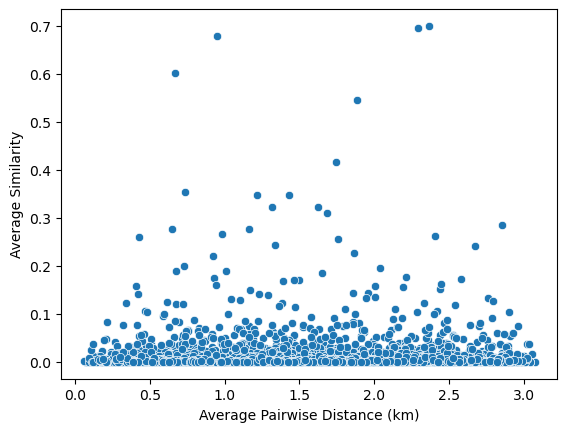

In [81]:
import seaborn as sns
# similarity_df_an_mean
sns.scatterplot(data = similarity_df_an_mean, x = 'mean_dist_pair', y = 'mean_similarity')
# x-label
plt.xlabel('Average Pairwise Distance (km)')
# y-label
plt.ylabel('Average Similarity')